In [ ]:
import requests
import json
import warnings
from datetime import date, timedelta




warnings.filterwarnings('ignore')

OK_200 = 200 ;
url = 'https://sinaica.inecc.gob.mx/index.php';
url_dat = 'https://sinaica.inecc.gob.mx/pags/datGrafs.php';

## Pollutants
pollutants = ["CO", "NO2", "O3", "SO2", "PM10", "PM2.5"]

def get_sinaica_data(url):
    response = requests.get(url, verify=False);
    response.raise_for_status();  # raises exception when not a 2xx response
    raw_string = response.text;
    return raw_string;
    
def get_monitoring_network_data(raw_string):    
    strings = raw_string.split('\n');
    for string in strings:
        data_string = string.strip();
        if data_string.startswith('var cump = {'):
            data_string = data_string.replace('var cump = ','');
            data_string = data_string.replace(';','');   
            monitoring_network_data = json.loads(data_string);
            return monitoring_network_data;
    monitoring_network_data = [];
    return monitoring_network_data;  

def get_monitoring_station_data(stations):
    
    stations_list = []
    for key, value in stations.items():
        stations_list.append({"ID":key, "NAME": stations[key]["nom"],\
                              "CODE": stations[key]["cod"],\
                              "LOC":{ "LAT":stations[key]["lat"], "LONG":stations[key]["long"]}});
    return stations_list;
        
def get_monitoring_stations_data(network):
    
    monitoring_stations_list = [];
    for key, value in network.items():
        stations_list = get_monitoring_station_data(network[key]["ests"])     
        monitoring_stations_list.append({"ID":key, "NAME": network[key]["nom"],\
                                                   "CODE": network[key]["cod"],\
                                                   "STATIONS": stations_list});
    return monitoring_stations_list;
    
def compute_monitoring_network_data_frame(monitoring_network_data): 
    monitoring_network_data_frame = []
    mnd = monitoring_network_data;
    for key, value in monitoring_network_data.items():
        if key != "time" and key != "date":
            monitoring_stations_data = get_monitoring_stations_data(mnd[key]["redes"])  
            monitoring_network_data_frame.append({"ID":key, "NAME":mnd[key]["nom"],\
                                                  "CODE":mnd[key]["cod"],\
                                                  "LOC":{ "LAT":mnd[key]["lat"], "LONG":mnd[key]["long"]},\
                                                  "NETWORK": monitoring_stations_data});
    return monitoring_network_data_frame;
    
def write_data(monitoring_network_data_frame):
    with open('sinaica_monitoring_stations.txt', 'w') as outfile:
        json.dump(monitoring_network_data_frame, outfile)
        
def get_station_data_string(url, station_id, param, ini_date, range_id):
    response = requests.post(url, data={'estacionId': station_id, 'param': param, 'fechaIni': ini_date, 'rango': range_id }, verify=False)
    response.raise_for_status();  # raises exception when not a 2xx response
    raw_string = response.text;
    return raw_string;     

def parse_station_data_string(raw_string):
    strings = raw_string.split('\n');
    for string in strings:
        data_string = string.strip();
        if data_string.startswith('var dat ='):
            data_string = data_string.replace('var dat =',''); 
            data_string = data_string.replace(';','');
            values = json.loads(data_string);
            return values;
    values = [];
    return values;         
        

# SINAICA monitoring stations data - web scraping
raw_string = get_sinaica_data(url);
monitoring_network_data = get_monitoring_network_data(raw_string);
monitoring_network_data_frame =  compute_monitoring_network_data_frame(monitoring_network_data);    
write_data(monitoring_network_data_frame)
#print(monitoring_network_data_frame)

# Print data summary


today = date.today()

for monitoring_network in monitoring_network_data_frame:
    print(monitoring_network["NAME"], \
          "(",  monitoring_network["CODE"],  ")", \
          "LAT: ", monitoring_network["LOC"]["LAT"], \
          "LONG: ",monitoring_network["LOC"]["LONG"]);
    for network in monitoring_network["NETWORK"]:
        print("    Red ", network["NAME"], \
              " (",  network["CODE"],  ")")
        for station in network["STATIONS"]:
            print("        Estación",station["ID"], \
              " (",  station["NAME"],  ")", \
              "LAT: ", station["LOC"]["LAT"], \
              "LONG: ",station["LOC"]["LONG"]);
            i = 0
            
            prevdays = today - timedelta(days=13)
            print(prevdays.strftime('%Y-%m-%d'))
            for pollutant in pollutants:
                raw_string = get_station_data_string(url_dat, station["ID"], pollutant, prevdays.strftime('%Y-%m-%d'), '3');
                values = parse_station_data_string(raw_string);
                print(pollutant)
                print(len(values))
                #data = []
                #for value in values:
                #    data.append(int(value["valor"]))
                #plt.plot(data)  
                #plt.show()


    












Aguascalientes ( AGS ) LAT:  21.88 LONG:  -102.3
    Red  Aguascalientes  ( AGS )
        Estación 31  ( CBTIS  ) LAT:  21.873311111111 LONG:  -102.32080277778
2022-01-05
CO
327
NO2
0
O3
327
SO2
327
PM10
327
PM2.5
327
        Estación 32  ( Secretaría de Medio Ambiente ) LAT:  21.84525 LONG:  -102.29125
2022-01-05
CO
0
NO2
0
O3
0
SO2
0
PM10
0
PM2.5
0
        Estación 33  ( Centro ) LAT:  21.883780555556 LONG:  -102.295825
2022-01-05
CO
0
NO2
0
O3
0
SO2
0
PM10
0
PM2.5
0
        Estación 303  ( Instituto Educativo ) LAT:  21.903277777778 LONG:  -102.27611111111
2022-01-05
CO
137
NO2
264
O3
264
SO2
264
PM10
264
PM2.5
264
Baja California - Estatal ( BC1 ) LAT:  32.58 LONG:  -116.16
    Red  Mexicali  ( MXC )
        Estación 39  ( COBACH ) LAT:  32.639722222222 LONG:  -115.50638888889
2022-01-05
CO
324
NO2
249
O3
324
SO2
0
PM10
0
PM2.5
324
        Estación 41  ( CESPM ) LAT:  32.603638888889 LONG:  -115.48594444444
2022-01-05
CO
0
NO2
0
O3
0
SO2
0
PM10
0
PM2.5
0
        Estación 371  ( UAB

In [79]:
# An example on how to extract pollution data
import requests
import json

url = 'https://sinaica.inecc.gob.mx/pags/datGrafs.php';
estacionId = '171'
param = 'PM2.5'
fechaIni = '2021-11-11'
rango = '4'
OK_200 = 200 ;

def get_station_data(url):
    response = requests.post(url, data={'estacionId': estacionId, 'param': param, 'fechaIni': fechaIni, 'rango': rango }, verify=False)
    response.raise_for_status();  # raises exception when not a 2xx response
    raw_string = response.text;
    return raw_string;     

def parse_station_data(raw_string):
    strings = raw_string.split('\n');
    for string in strings:
        data_string = string.strip();
        if data_string.startswith('var dat ='):
            data_string = data_string.replace('var dat =',''); 
            data_string = data_string.replace(';','');
            values = json.loads(data_string);
            return values;
    values = [];
    return values;  

def write_data(values):
    with open('values.txt', 'w') as outfile:
        json.dump(values, outfile)

raw_string = get_station_data(url)
values = parse_station_data(raw_string)
write_data(values)

data = []
for value in values:
    data.append(int(value["valor"]))


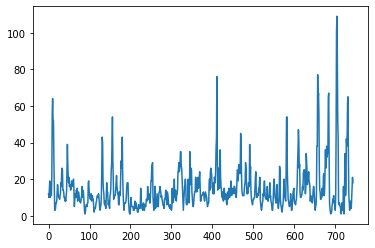

In [80]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.show()

In [81]:
len(data)


744

In [56]:
from datetime import date
today = date.today()
print(today)


2022-01-18


In [57]:
today

datetime.date(2022, 1, 18)

In [65]:
from datetime import date
today = date.today()
today.strftime('%Y-%m-%d')

'2022-01-18'